## DANN(Doain Adversial Neural Network)

In [141]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

### Generate Source Samples

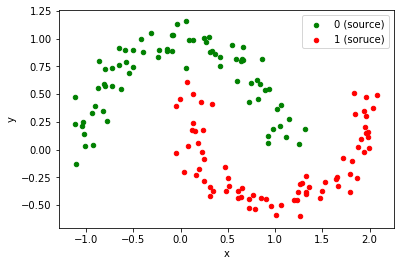

In [142]:
num_samples = 150
X, y = make_moons(n_samples=num_samples, noise=0.1)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {1:'red', 0:'green'}
labels = {1:'1 (soruce)', 0:'0 (source)'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=labels[key], color=colors[key])
pyplot.show()

### Generate Target Samples

/Users/seokinj/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


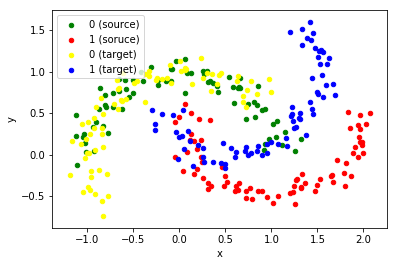

In [143]:
# rotate degree of 35
ang = np.radians(35)
xsin = np.multiply(np.sin(ang), df.x)
xcos = np.multiply(np.cos(ang), df.x)
ysin = np.multiply(np.sin(ang), df.y)
ycos = np.multiply(np.cos(ang), df.y)

X2 = np.concatenate(((xcos-ysin).reshape(1,num_samples), (xsin+ycos).reshape(1,num_samples)), axis=0).T
df2 = DataFrame(dict(x=X2[:,0], y=X2[:,1], label=y))
colors2 = {1:'blue', 0:'yellow'}
labels2 = {1:'1 (target)', 0:'0 (target)'}
fig, ax = pyplot.subplots()
grouped2 = df2.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=labels[key], color=colors[key])
for key, group in grouped2:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=labels2[key], color=colors2[key])    

pyplot.show()

### NN(Neural Net) - hidden layer(15)

In [144]:
input_sz = 2
hidden_sz = 15
num_classes = 2
num_epochs = 100
batch_sz = 150
learning_rate = 0.02
hyper = 6

class Net(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_sz, hidden_sz)
        self.sig = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_sz, num_classes)
        self.soft = nn.Softmax()
        self.fc3 = nn.Linear(hidden_sz, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        gf = self.sig(out) # Gf 
        out = self.fc2(gf)
        out = self.soft(out)
        return gf, out

### DANN(Domain Adversarial NN) - hidden layer(15)

In [145]:
class DANN(nn.Module):
    def __init__(self, hidden_sz, num_classes):
        super(DANN, self).__init__()
        self.fc3 = nn.Linear(hidden_sz, num_classes)
        self.sig = nn.Sigmoid()
        
    def forward(self, x): # x : Gf(x)
        out = self.fc3(x)
        out = self.sig(out) # Gd(Gf) 
        return out 

### Train the Model - without DA

In [146]:
net = Net(input_sz, hidden_sz, num_classes)
dann = DANN(hidden_sz, num_classes)

source_labels = torch.zeros(1,2)
source_domain = torch.zeros(1,2)
target_domain = torch.zeros(1,2)

def doDA(d, x): # d : domain type / x : Gf
    output = dann(x)
    if d == 1:
        l = criterion(output, Variable(source_domain))
    elif d == 0:
        l = criterion(output, Variable(target_domain))
    return l
        
# Loss 
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(dann.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i in range(0, num_samples):
        source_labels[0][y[i]] = 1.0
        s_data = Variable(torch.FloatTensor(X[i]).view(-1,2))
        s_labels = Variable(source_labels)
        
        gf, outputs = net(s_data) # Basic NN
        loss = criterion(outputs, s_labels)
        
        #loss.backward()
        
        # Domain adaptation regularizer (source 1)
        source_domain[0][1] = 1.0
        loss_source = doDA(1, gf)    
        
        # Domain adaptation regularizer (target 0)
        t_data = Variable(torch.FloatTensor(X2[i]).contiguous().view(-1,2))
        gf, outputs = net(t_data)
        target_domain[0][0] = 1.0
        loss_target = doDA(0, gf)
        
        # Total Loss
        total_loss = loss - hyper * (loss_source + loss_target)
        total_loss.backward()
        
        # Update Parameters
        for name, param in net.named_parameters():
            if name in 'fc1.bias':
                param.data = param.data - learning_rate * param.grad.data
            if name in 'fc1.weight':
                param.data = param.data - learning_rate * param.grad.data
            if name in 'fc2.bias':
                param.data = param.data - learning_rate * param.grad.data
            if name in 'fc2.weight':
                param.data = param.data - learning_rate * param.grad.data
        
        for name, param in dann.named_parameters():
            if name in 'fc3.bias':
                param.data = param.data + learning_rate * param.grad.data
                
            elif name in 'fc3.weight':    
                param.data = param.data + learning_rate * param.grad.data
        
        # zero the gradient buffer
        optimizer.zero_grad()
        optimizer2.zero_grad()

/Users/seokinj/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Test the model

/Users/seokinj/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 1 0]
{1: 'blue', 0: 'yellow'}
{1: '1 (target)', 0: '0 (target)'}


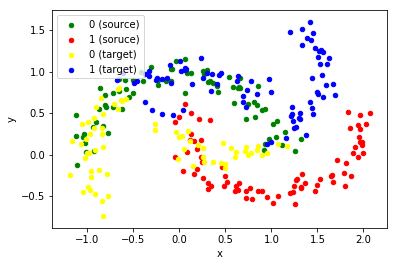

In [147]:
Z = np.zeros(1,)
for i in range(0, num_samples):
    test_dat = Variable(torch.FloatTensor(X2[i]).contiguous().view(-1,2))
    outputs = net(test_dat)[1]
    Z = np.append(Z, torch.max(outputs.data, 1)[1])

Z = Z.astype(np.int64)
Z = np.delete(Z, Z[0])
print(Z)

print(colors2)
print(labels2)
df2 = DataFrame(dict(x=X2[:,0], y=X2[:,1], label=Z))
fig, ax = pyplot.subplots()
grouped2 = df2.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=labels[key], color=colors[key])
for key, group in grouped2:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=labels2[key], color=colors2[key])    


#pyplot.scatter(X[:,0], X[:,1], c=y, cmap=pyplot.cm.Spectral)
#pyplot.scatter(X2[:,0], X2[:,1], c=Z)
pyplot.show()

### NOTE

In [ ]:
####### type ########
        # tmp : Float Tensor#
        # u : Parametor     #
        # in_da : Variable  #
        #####################
        
        ####################### size ######################
        # d : [2]                                         #
        # delta_d : [2] = [1,2]                           #
        # u : [2,15]                                      #
        # in_data : [1,15]                                #
        # tmp : [1,2] @ [2,15] * [1,15] * [1,15] = [1,15] #
        # b : [15] = [15,1]                               #
        # delta_b : [15,1]                                #
        # w : [15,2]                                      #
        # data.data : [2,1]                               #
        # delta_w : [15,2]                                #
        ###################################################
        
        
"""Origin
        loss3.backward()

        for name, param in dann.named_parameters():
            if name in 'fc3.weight':
                delta_u2 = delta_u + (-1 * hyper * param.grad.data)
            else:
                k = -1 * hyper * param.grad.data
                delta_d2 = delta_d + k

        tmp2 = k.view(1,2) @ u.data * in_da2.data * (1-in_da2.data) 

        delta_b = delta_b + tmp2.t()
        delta_w = delta_w + tmp2.t() @ target_data.data
        

        # Update NN parameters
        for name, param in net.named_parameters():
            if name in 'fc1.bias':
                param.data = param.data - learning_rate * delta_b.view(15)
            if name in 'fc1.weight':
                param.data = param.data - learning_rate * delta_w
            if name in 'fc2.bias':
                param.data = param.data - learning_rate * param.grad.data
            if name in 'fc2.weight':
                param. data = param.data - learning_rate * param.grad.data
        
        # Update DANN parameters
        for name, param in dann.named_parameters():
            if name in 'fc3.bias':
                param.data = param.data + learning_rate * delta_d2
                
            if name in 'fc3.weight':    
                param.data = param.data + learning_rate * delta_u2
        
        # zero the gradient buffer
        for param in net.parameters():
            param.grad.data.zero_()
        for param in dann.parameters():
            param.grad.data.zero_()

        if (i+1) % 50 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, i+1, len(df)//batch_sz, loss.data[0]-hyper*(loss2.data[0]+loss3.data[0])))
        """        